<a href="https://colab.research.google.com/github/julieta87/STATGR-5243-Project1/blob/main/yellow_taxi_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Initial data shape: (37501349, 19)
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2024-01-01 00:57:55   2024-01-01 01:17:43              1.0   
1         1  2024-01-01 00:03:00   2024-01-01 00:09:36              1.0   
2         1  2024-01-01 00:17:06   2024-01-01 00:35:01              1.0   
3         1  2024-01-01 00:36:38   2024-01-01 00:44:56              1.0   
4         1  2024-01-01 00:46:51   2024-01-01 00:52:57              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.72         1.0                  N           186            79   
1           1.80         1.0                  N           140           236   
2           4.70         1.0                  N           236            79   
3           1.40         1.0                  N            79           211   
4           0.80         1.0                  N           211           148   

   payment_ty

<ipython-input-1-a846ac591532>:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


Shape after filtering durations <0 or >6 hrs: (37108788, 22)
Shape after outlier removal: (24472713, 22)

--- SUMMARY STATISTICS ---
            VendorID           tpep_pickup_datetime  \
count   2.447271e+07                       24472713   
unique           NaN                            NaN   
top              NaN                            NaN   
freq             NaN                            NaN   
mean    1.763226e+00  2024-06-20 04:18:25.270651136   
min     1.000000e+00            2024-01-01 00:00:00   
25%     2.000000e+00            2024-03-29 15:36:13   
50%     2.000000e+00            2024-06-15 20:47:39   
75%     2.000000e+00            2024-09-16 13:59:34   
max     2.000000e+00            2024-12-01 22:04:33   
std     4.251022e-01                            NaN   

                tpep_dropoff_datetime  passenger_count  trip_distance  \
count                        24472713       24472713.0   2.447271e+07   
unique                            NaN              NaN      

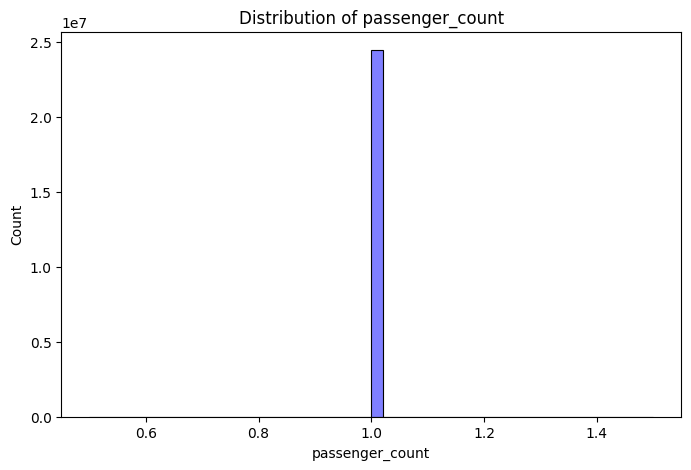

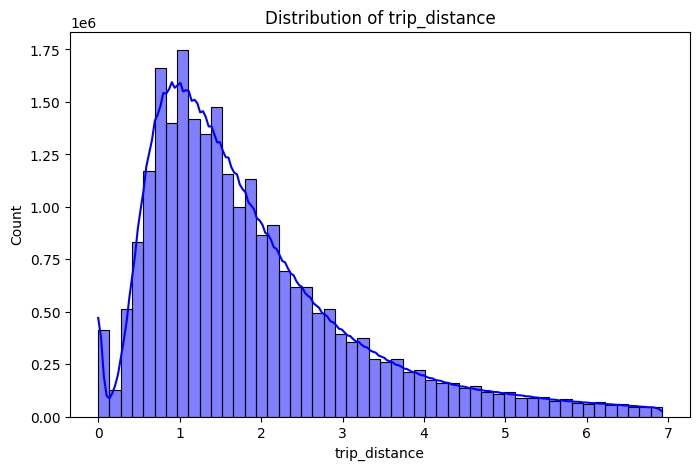

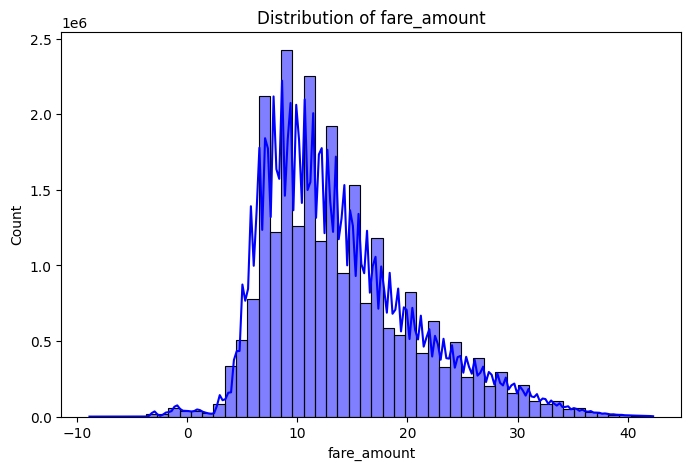

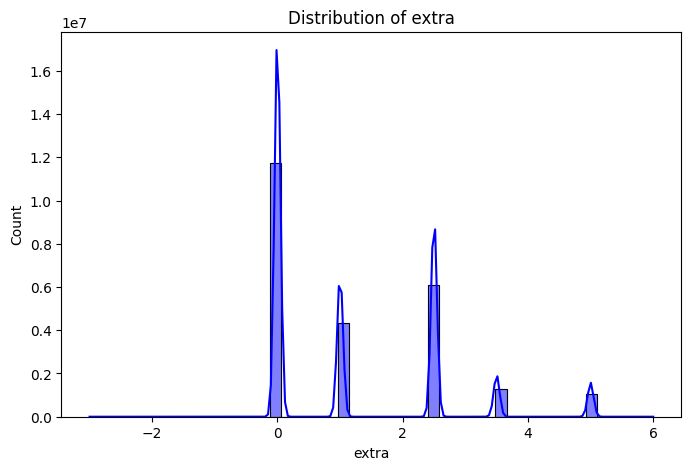

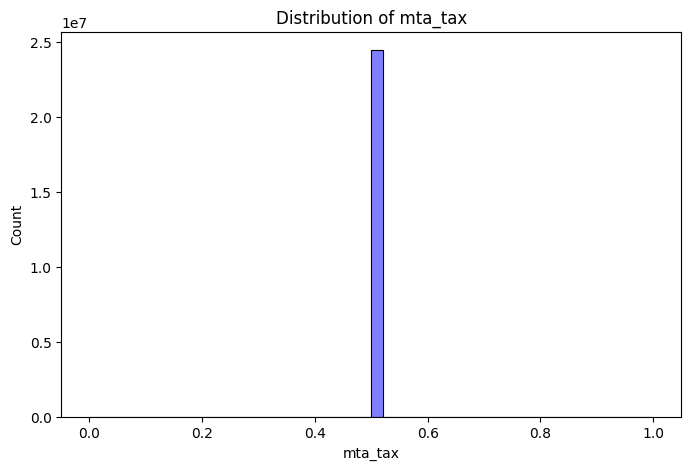

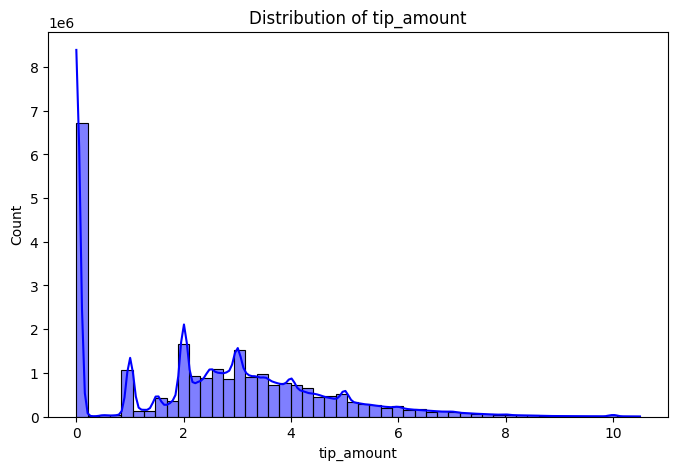

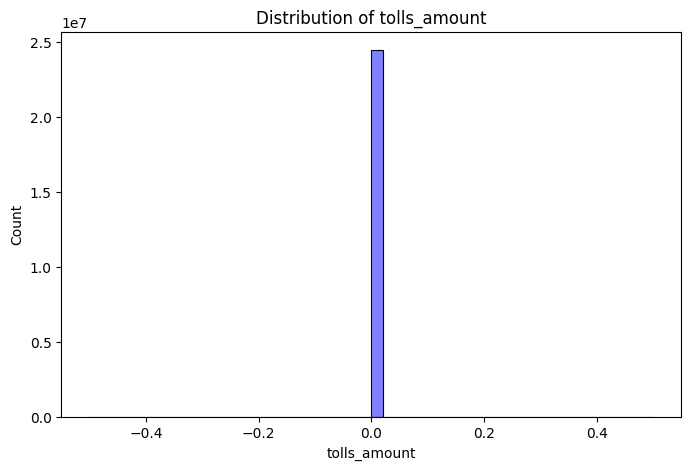

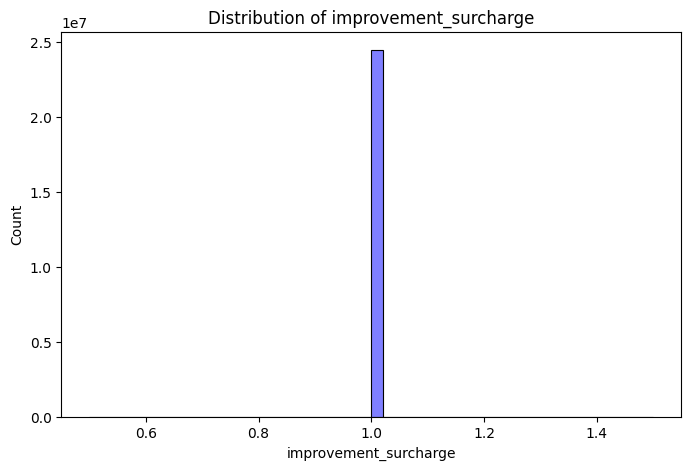

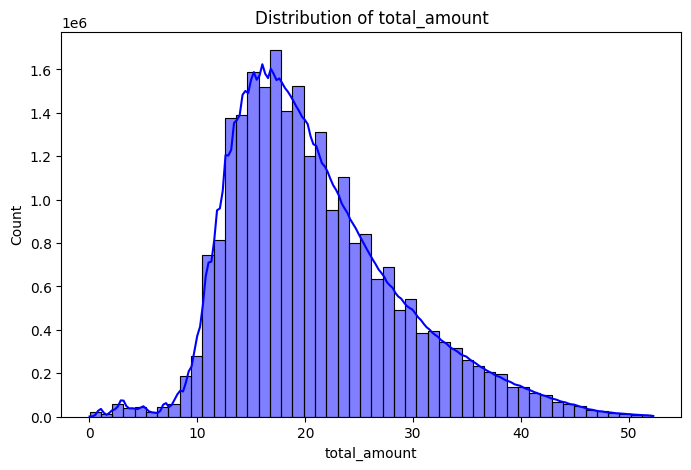

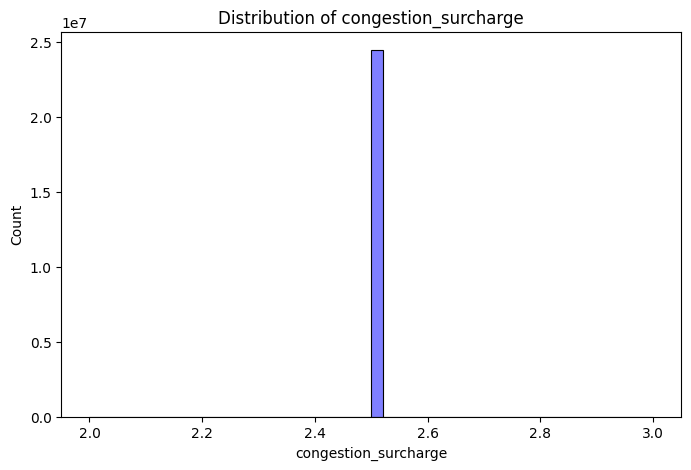

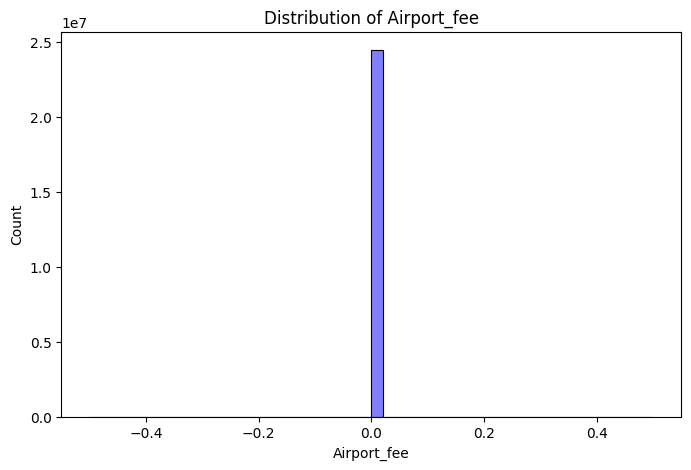

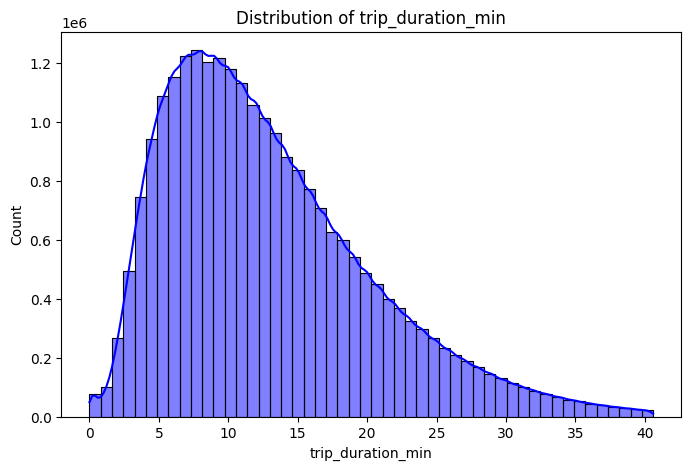

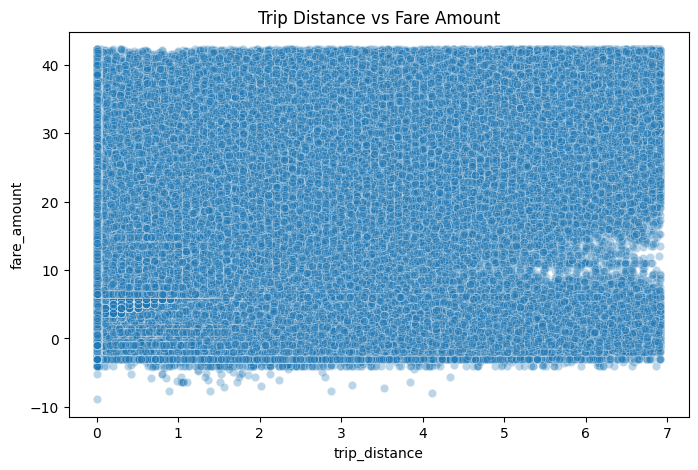

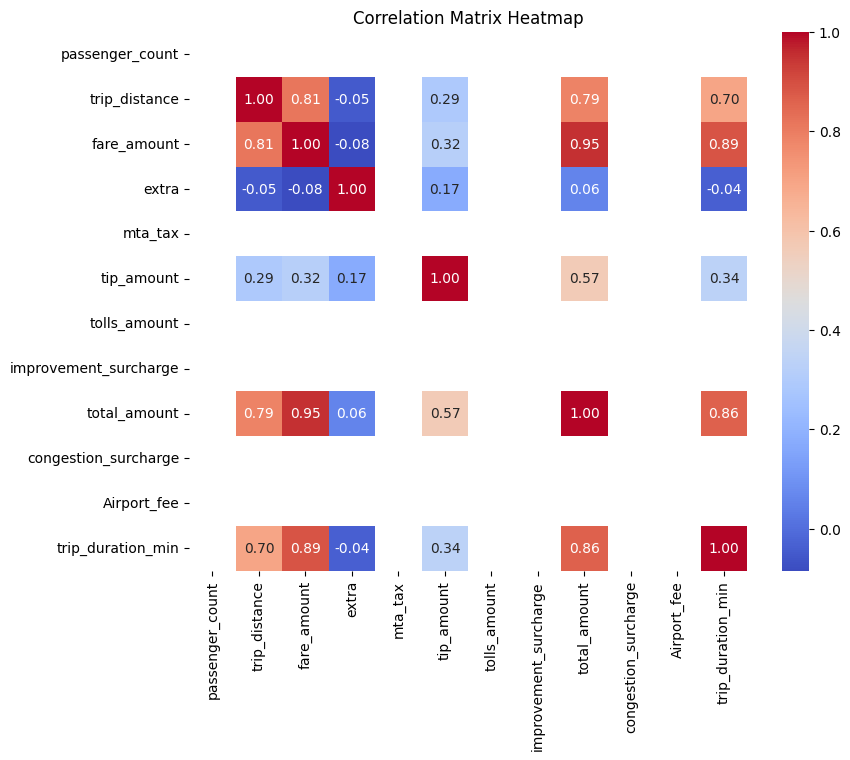

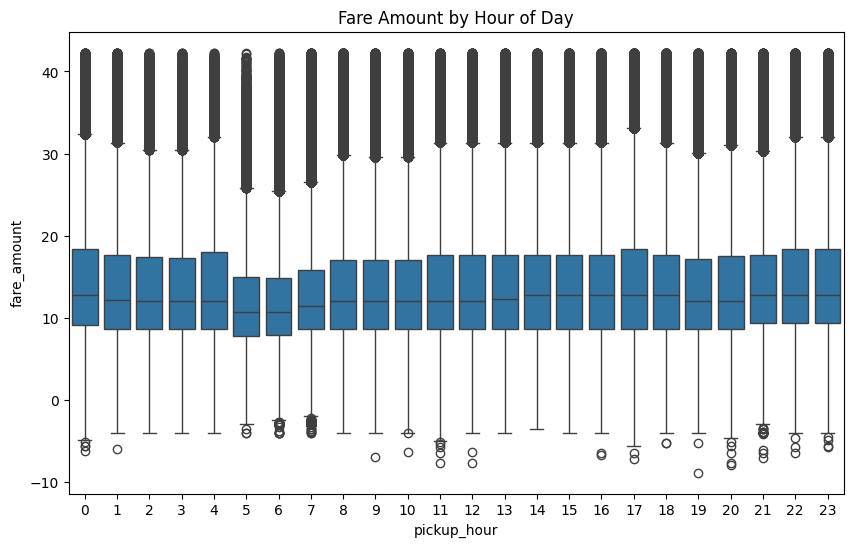


Final cleaned data saved to 'Cleaned_Yellow_Taxi_Data_2024.csv'
Final DataFrame shape: (24472713, 37)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# 1) LOAD THE MERGED CSV
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv(
    "/content/drive/MyDrive/STAT5243_Project1_2024_taxi_data/merged_yellow_tripdata_2024_JanNov.csv",
    low_memory=False
)

print("Initial data shape:", df.shape)
print(df.head())

# 2) BASIC DATA CLEANING
# a) Convert pickup/dropoff to datetime
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'], errors='coerce')

# b) Remove duplicates
df.drop_duplicates(inplace=True)

# c) Drop rows missing critical times
df.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True)

# d) Convert relevant columns to numeric if needed
numeric_cols = [
    'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
    'tip_amount', 'tolls_amount', 'improvement_surcharge',
    'total_amount', 'congestion_surcharge', 'Airport_fee'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# e) Filter to only 2024 pickups & dropoffs (some rows have years like 2002 or 2026)
df = df[
    (df['tpep_pickup_datetime'].dt.year == 2024) &
    (df['tpep_dropoff_datetime'].dt.year == 2024)
]
print("Shape after filtering to 2024 only:", df.shape)

# f) Impute or remove remaining missing numeric data
for col in numeric_cols:
    if col in df.columns:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

# 3) FEATURE ENGINEERING (TRIP DURATION)

# Create trip_duration in minutes
df['trip_duration_min'] = (
    df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
).dt.total_seconds() / 60.0

# Extract date/hour for time-based EDA
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour

# 4) REMOVE CLEARLY INVALID / ANOMALOUS RECORDS

# a) If passenger_count is always 1, that might be normal for the dataset,
#    but if we want to remove unusual passenger counts (like 0), do:
if 'passenger_count' in df.columns:
    df = df[df['passenger_count'] > 0]  # remove zero passengers

# b) Filter out negative or extremely long durations (like, more than 6 hours = 360 min)
df = df[(df['trip_duration_min'] >= 0) & (df['trip_duration_min'] <= 360)]
print("Shape after filtering durations <0 or >6 hrs:", df.shape)


# 5) DETECT & REMOVE OUTLIERS
#    - The default IQR 1.5 can remove ~35% of the data. so we might consider
#      a more permissive multiplier (like 3.0) or skip entirely.

def remove_outliers_iqr(dataframe, columns, multiplier=1.5):
    """
    Removes rows where any specified columns are outliers based on IQR.
    """
    Q1 = dataframe[columns].quantile(0.25)
    Q3 = dataframe[columns].quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((dataframe[columns] < (Q1 - multiplier * IQR)) |
             (dataframe[columns] > (Q3 + multiplier * IQR))).any(axis=1)
    return dataframe[mask]

# Try a less-aggressive approach if 1.5 is too high:
outlier_multiplier = 1.5  # Or 2.0 or 3.0 or so
df = remove_outliers_iqr(df, numeric_cols + ['trip_duration_min'], outlier_multiplier)
print("Shape after outlier removal:", df.shape)

# 6) EXPLORATORY DATA ANALYSIS (EDA)
print("\n--- SUMMARY STATISTICS ---")
print(df.describe(include='all'))

print("\n--- DATAFRAME INFO ---")
print(df.info())

# a) Distribution Plots
for col in numeric_cols + ['trip_duration_min']:
    if col in df.columns:
        plt.figure(figsize=(8,5))
        sns.histplot(data=df, x=col, bins=50, kde=True, color="blue")
        plt.title(f"Distribution of {col}")
        plt.show()

# b) Scatter: trip_distance vs fare_amount
if 'trip_distance' in df.columns and 'fare_amount' in df.columns:
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df, x='trip_distance', y='fare_amount', alpha=0.3)
    plt.title("Trip Distance vs Fare Amount")
    plt.show()

# c) Correlation Matrix
num_for_corr = numeric_cols + ['trip_duration_min']
num_for_corr = [c for c in num_for_corr if c in df.columns]
corr_matrix = df[num_for_corr].corr()

plt.figure(figsize=(9,7))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

# d) Box Plot: Fare Amount by Hour of Day
if 'pickup_hour' in df.columns and 'fare_amount' in df.columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x='pickup_hour', y='fare_amount')
    plt.title("Fare Amount by Hour of Day")
    plt.show()


# 7) DATA PREPROCESSING (SCALING & ENCODING)

scaler = MinMaxScaler()
for col in numeric_cols + ['trip_duration_min']:
    if col in df.columns:
        df[col + "_scaled"] = scaler.fit_transform(df[[col]])

# Encode categorical columns if needed
cat_cols = []
if 'store_and_fwd_flag' in df.columns:
    cat_cols.append('store_and_fwd_flag')
if 'VendorID' in df.columns:
    cat_cols.append('VendorID')
if 'payment_type' in df.columns:
    cat_cols.append('payment_type')

for col in cat_cols:
    le = LabelEncoder()
    df[col + "_encoded"] = le.fit_transform(df[col].astype(str))

# 8) SAVE CLEANED/PREPROCESSED DATA

output_csv = "Cleaned_Yellow_Taxi_Data_2024.csv"
df.to_csv(output_csv, index=False)
print(f"\nFinal cleaned data saved to '{output_csv}'")
print("Final DataFrame shape:", df.shape)

In [ ]:
# Save directly into my folder in Drive:
df.to_csv("/content/drive/MyDrive/STAT5243_Project1_2024_taxi_data/Cleaned_Yellow_Taxi_Data_2024.csv", index=False)